# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.optimize as opt
import scipy.stats as st
import time

# Auxiliary functions

In [2]:
def loss(X,y,β,τ):
    return 0.5*la.norm(y-X@β)**2+τ*la.norm(β,ord=1)

In [3]:
def dual(X,y,A,b,λ,ν):
    Q = la.inv(np.transpose(X)@X)
    r = np.transpose(X)@y-np.transpose(A)@λ-ν
    return 0.5*r@Q@r+b@λ-0.5*y@y

In [4]:
def ball(β,τ):
    m = len(β)
    Bβ = np.zeros(m)
    for i in range(m):
        Bβ[i] = np.sign(β[i])*(τ-np.max(np.array([τ-np.abs(β[i]),0])))
    return Bβ 

In [5]:
def soft(β,τ):
    m = len(β)
    Sβ = np.zeros(m)
    for i in range(m):
        Sβ[i] = np.sign(β[i])*np.max(np.array([np.abs(β[i])-τ,0]))
    return Sβ

In [6]:
def part(β):
    m = len(β)
    Pβ = np.zeros(m)
    for i in range(m):
        Pβ[i] = np.max(np.array([β[i],0]))
    return Pβ

In [7]:
def proj(z,A,b,T,η):
    if np.all(A@z<=b):
        return z
    else:
        k = len(b)
        λ_curr = np.zeros(k)
        D_hist = np.zeros(T)
        λ_hist = np.zeros((T,k))
        for t in range(T):
            g_curr = A@np.transpose(A)@λ_curr-(A@z-b)
            λ_next = part(λ_curr-η*g_curr)
            D_hist[t] = 0.5*la.norm(np.transpose(A)@λ_next)**2-(A@z-b)@λ_next
            λ_hist[t,:] = λ_next
            λ_curr = λ_next
        # plt.plot(D_hist)
        # plt.grid()
        # plt.show()
        return z-np.transpose(A)@λ_hist[-1]

# Toy Example

In [8]:
np.random.seed(432)

n = 200
m = 2
β = np.array([0.5,-0.2])
σ = 0.5
X = np.random.normal(size=(n,m))
y = X@β+np.random.normal(scale=σ,size=n)
τ = 10

A = np.array([[-1,0],
              [0,-1],
              [1,1]])
b = np.array([0,0,1])

k = len(b)

0.06 seconds


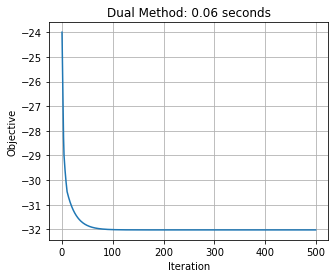

In [9]:
# Dual Projected Gradient Descent

time_0 = time.time()

A_tilde = np.vstack((A,np.eye(m)))
b_tilde = np.hstack((b,np.zeros(m)))

Q = A_tilde@la.pinv(np.transpose(X)@X)@np.transpose(A_tilde)
r = A_tilde@la.pinv(np.transpose(X)@X)@np.transpose(X)@y

T = 500
η = 5

λ_curr = np.zeros(k)
ν_curr = np.zeros(m)
D_hist = np.zeros(T)
λ_hist = np.zeros((T,k))
ν_hist = np.zeros((T,m))
for t in range(T):
    λν_curr = np.hstack((λ_curr,ν_curr))
    g_curr = Q@λν_curr-r+b_tilde
    λν_next = λν_curr-η*g_curr
    λ_next = part(λν_next[:k])
    ν_next = ball(λν_next[k:],τ)
    D_hist[t] = dual(X,y,A,b,λ_next,ν_next)
    λ_hist[t,:] = λ_next
    ν_hist[t,:] = ν_next
    λ_curr = λ_next
    ν_curr = ν_next
    
β_dual = la.pinv(np.transpose(X)@X)@(np.transpose(X)@y-np.transpose(A)@λ_curr-ν_curr)

time_1 = time.time()    
print(np.round(time_1-time_0,3),"seconds")
    
plt.figure(figsize=(5,4))
plt.title("Dual Method: "+str(np.round(time_1-time_0,3))+" seconds")
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.plot(D_hist)
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\STAT 432\stat432-project\dualm.png")
plt.show()

In [10]:
β_dual_hist = np.zeros((T,m))
for t in range(T):
    β_dual_hist[t] = la.pinv(np.transpose(X)@X)@(np.transpose(X)@y-np.transpose(A)@λ_hist[t]-ν_hist[t])

3.719 seconds


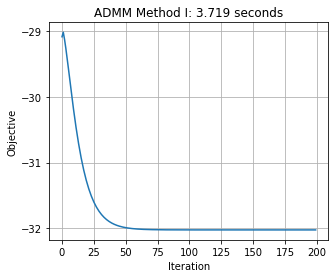

In [11]:
# Alternating Direction Method of Multipliers 1

time_0 = time.time()

T_outer = 200
T_inner = 200

η_1 = 1e-3
η_2 = 1e-1
α = 20

β_curr = np.zeros(m)
γ_curr = np.zeros(m)
u_curr = np.zeros(m)
L_hist = np.zeros(T_outer)
β_hist = np.zeros((T_outer,m))
γ_hist = np.zeros((T_outer,m))
u_hist = np.zeros((T_outer,m))

for t in range(T_outer):
    β_in_curr = β_curr
    L_in_hist = np.zeros(T_inner)
    β_in_hist = np.zeros((T_inner,m))
    for s in range(T_inner):
        g_in_curr = np.transpose(X)@(X@β_in_curr-y)+α*(β_in_curr-γ_curr+u_curr)
        β_in_next = soft(β_in_curr-η_1*g_in_curr,τ*η_1)
        L_in_hist[s] = 0.5*la.norm(X@β_in_next-y)**2+0.5*α*la.norm(β_in_curr-γ_curr+u_curr)**2
        β_in_hist[s,:] = β_in_next
        β_in_curr = β_in_next
    # plt.plot(L_in_hist)
    # plt.grid()
    # plt.show()
    β_next = β_in_curr
    γ_next = proj(β_next+u_curr,A,b,T_inner,η_2)
    u_next = u_curr+β_next-γ_next
    L_hist[t] = -loss(X,y,β_next,τ)
    β_hist[t,:] = β_next
    γ_hist[t,:] = γ_next
    u_hist[t,:] = u_next
    β_curr = β_next
    γ_curr = γ_next
    u_curr = u_next
    
time_1 = time.time()
print(np.round(time_1-time_0,3),"seconds")
    
plt.figure(figsize=(5,4))
plt.title("ADMM Method I: "+str(np.round(time_1-time_0,3))+" seconds")
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.yticks(np.array([-29,-30,-31,-32]))
plt.plot(L_hist)
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\STAT 432\stat432-project\admm1.png")
plt.show()

In [12]:
β_hist_1 = β_hist

2.451 seconds


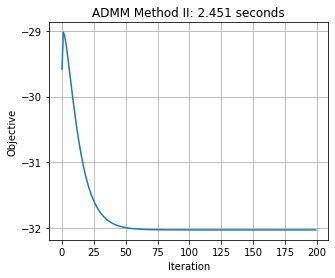

In [13]:
# Alternating Direction Method of Multipliers 2

time_0 = time.time()

T_outer = 200
T_inner = 200

η = 1e-3
α = 20

β_curr = np.zeros(m)
ζ_curr = np.zeros(k)
u_curr = np.zeros(k)
L_hist = np.zeros(T_outer)
β_hist = np.zeros((T_outer,m))
ζ_hist = np.zeros((T_outer,k))
u_hist = np.zeros((T_outer,k))

for t in range(T_outer):
    β_in_curr = β_curr
    L_in_hist = np.zeros(T_inner)
    β_in_hist = np.zeros((T_inner,m))
    for s in range(T_inner):
        g_in_curr = np.transpose(X)@(X@β_in_curr-y)+α*np.transpose(A)@(A@β_in_curr+ζ_curr-b+u_curr)
        β_in_next = soft(β_in_curr-η*g_in_curr,τ*η)
        L_in_hist[s] = 0.5*la.norm(X@β_in_next-y)**2+0.5*α*la.norm(A@β_in_next+ζ_curr-b+u_curr)**2
        β_in_hist[s,:] = β_in_next
        β_in_curr = β_in_next
    # plt.plot(L_in_hist)
    # plt.grid()
    # plt.show()
    β_next = β_in_curr
    ζ_next = part(-(A@β_next-b+u_curr))
    u_next = u_curr+A@β_next+ζ_next-b
    L_hist[t] = -loss(X,y,β_next,τ)
    β_hist[t,:] = β_next
    ζ_hist[t,:] = ζ_next
    u_hist[t,:] = u_next
    β_curr = β_next
    ζ_curr = ζ_next
    u_curr = u_next
    
time_1 = time.time()
print(np.round(time_1-time_0,3),"seconds")
    
plt.figure(figsize=(5,4))
plt.title("ADMM Method II: "+str(np.round(time_1-time_0,3))+" seconds")
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.yticks(np.array([-29,-30,-31,-32]))
plt.plot(L_hist)
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\STAT 432\stat432-project\admm2.png")
plt.show()

In [14]:
β_hist_2 = β_hist

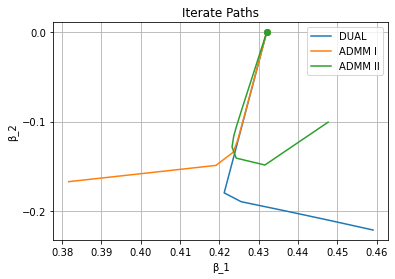

In [15]:
plt.title("Iterate Paths")
plt.xlabel("β_1")
plt.ylabel("β_2")
plt.yticks(np.array([0,-0.1,-0.2]))
# plt.plot(β[0],β[1],marker='o',color='k')
plt.plot(β_dual_hist[:,0],β_dual_hist[:,1],color='C0',label='DUAL')
plt.plot(β_dual_hist[-1,0],β_dual_hist[-1,1],marker='o',color='C9')
plt.plot(β_hist_1[:,0],β_hist_1[:,1],color='C1',label='ADMM I')
plt.plot(β_hist_1[-1,0],β_hist_1[-1,1],marker='o',color='C1')
plt.plot(β_hist_2[:,0],β_hist_2[:,1],color='C2',label='ADMM II')
plt.plot(β_hist_2[-1,0],β_hist_2[-1,1],marker='o',color='C2')
plt.legend()
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\STAT 432\stat432-project\paths.png")
plt.show()

# Application: Portfolio Optimization

In [16]:
data_str = "oilgas-10y"
S_df = pd.read_csv("C:\\Users\\zhubr\\OneDrive\\Desktop\\STAT 432\\data-"+data_str+".csv")

S_df = S_df.drop(columns=['Date'])
S_df = S_df.iloc[::-1].astype('float')
S_df.head()
S = S_df.to_numpy()

In [17]:
S_in = S[1800:2200,:]
S_out = S[2200:2300,:]

def mvpo(S,τ,T,η):
    
    R = np.zeros((np.shape(S)[0]-1,np.shape(S)[1]))
    for t in range(np.shape(R)[0]):
        for i in range(np.shape(R)[1]):
            R[t,i] = 100*(S[t+1,i]/S[t,i]-1)
            
    μ = np.mean(R,axis=0)
    Σ = np.cov(np.transpose(R))
    Σ_inv = la.inv(Σ)
    Σ_sqrt = la.sqrtm(Σ)
    Σ_inv_sqrt = la.sqrtm(Σ_inv)
    
    n = Σ.shape[0]
    m = Σ.shape[1]
    w = np.ones(m)/m
    X = Σ_sqrt
    y = Σ_inv_sqrt@μ

    A = np.array([np.ones(m),-np.ones(m)])
    b = np.array([1,-1])
    k = len(b)

    time_0 = time.time()

    A_tilde = np.vstack((A,np.eye(m)))
    b_tilde = np.hstack((b,np.zeros(m)))

    Q = A_tilde@la.inv(np.transpose(X)@X)@np.transpose(A_tilde)
    r = A_tilde@la.inv(np.transpose(X)@X)@np.transpose(X)@y

    λ_curr = np.zeros(k)
    ν_curr = np.zeros(m)
    D_hist = np.zeros(T)
    λ_hist = np.zeros((T,k))
    ν_hist = np.zeros((T,m))
    for t in range(T):
        λν_curr = np.hstack((λ_curr,ν_curr))
        g_curr = Q@λν_curr-r+b_tilde
        λν_next = λν_curr-η*g_curr
        λ_next = part(λν_next[:k])
        ν_next = ball(λν_next[k:],τ)
        D_hist[t] = dual(X,y,A,b,λ_next,ν_next)
        λ_hist[t,:] = λ_next
        ν_hist[t,:] = ν_next
        λ_curr = λ_next
        ν_curr = ν_next

    β_dual = la.inv(np.transpose(X)@X)@(np.transpose(X)@y-np.transpose(A)@λ_curr-ν_curr)

    time_1 = time.time()
    print(np.round(time_1-time_0,3),"seconds")

    plt.plot(D_hist)
    plt.grid()
    plt.show()
    
    return β_dual

0.297 seconds


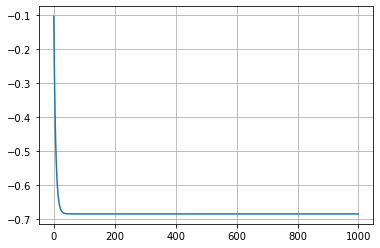

0.491 seconds


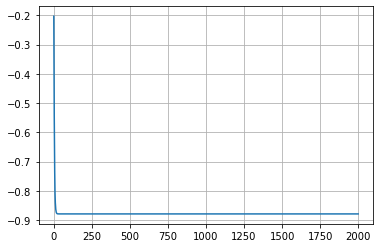

0.485 seconds


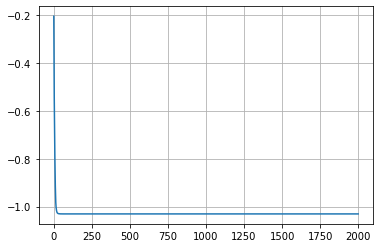

0.494 seconds


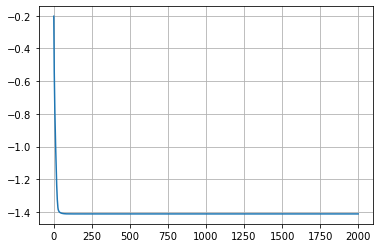

In [18]:
w_0 = mvpo(S_in,0,1000,1e-1)
w_I = mvpo(S_in,0.1,2000,2e-1)
w_V = mvpo(S_in,0.2,2000,2e-1)
w_X = mvpo(S_in,0.5,2000,2e-1)

In [19]:
P_0 = np.zeros(np.shape(S_out)[0])
P_I = np.zeros(np.shape(S_out)[0])
P_V = np.zeros(np.shape(S_out)[0])
P_X = np.zeros(np.shape(S_out)[0])
for t in range(len(P_0)):
    P_0[t] = w_0@S_out[t,:]
    P_I[t] = w_I@S_out[t,:]
    P_V[t] = w_V@S_out[t,:]
    P_X[t] = w_X@S_out[t,:]

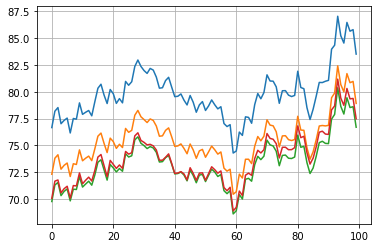

In [20]:
plt.plot(P_0)
plt.plot(P_I)
plt.plot(P_V)
plt.plot(P_X)
plt.grid()
plt.show()

In [21]:
w_0

array([-0.01057917,  0.13786234,  0.05240739,  0.02874558,  0.13143258,
       -0.03973589, -0.24010718,  0.1233319 ,  0.03703367,  0.35531833,
        0.36567046, -0.03111252, -0.18089783,  0.16731828,  0.04685479,
        0.08558459, -0.11218328,  0.10304567, -0.04515014,  0.02516043])

In [22]:
w_I

array([-4.59138935e-16,  5.98110543e-02, -6.48187674e-17,  1.07411542e-02,
        1.11073710e-01, -4.91930454e-03, -9.73125933e-02,  1.13169235e-01,
        2.31986567e-16,  3.46078158e-01,  3.90253589e-01,  3.23041707e-16,
       -1.65041079e-01,  1.46525650e-01,  7.97711061e-17,  4.69667303e-02,
       -7.87596678e-02,  1.06982046e-01, -6.57048427e-18,  1.44313173e-02])

In [23]:
w_V

array([-3.94365849e-16, -3.03569781e-16,  2.23171273e-17, -3.00828886e-16,
        5.77587001e-02, -4.25570736e-17, -8.15194805e-18,  1.01849204e-01,
        2.39641447e-16,  3.60739341e-01,  4.01639931e-01,  3.00211835e-16,
       -1.51400302e-01,  1.31608017e-01, -7.56545952e-17,  4.91440954e-03,
       -3.67042529e-02,  1.24518191e-01,  2.41071168e-17,  5.07676092e-03])

In [24]:
w_X

array([ 3.21052710e-15,  2.70616738e-15,  1.44837182e-15,  4.35477604e-16,
        2.78891290e-02,  5.17678104e-15,  1.60663604e-15,  5.87967351e-02,
        2.09057683e-15,  3.76671421e-01,  3.80308893e-01, -7.40027936e-16,
       -9.46816435e-02,  1.05235808e-01,  6.55956319e-15,  1.68106827e-15,
        4.91902318e-15,  1.45779658e-01,  5.58518092e-15,  1.97524551e-15])

In [25]:
P_0[-1]/P_0[0]

1.0894982169372711

In [26]:
P_I[-1]/P_I[0]

1.09143244850706

In [27]:
P_V[-1]/P_V[0]

1.099430958547247

In [28]:
P_X[-1]/P_X[0]

1.1060144087997328